In [1]:
TRAIN_DATA_SIZE = 500

from sklearn.datasets import make_moons

train_data = make_moons(n_samples=TRAIN_DATA_SIZE, noise=0.1, random_state=0)
val_data = make_moons(n_samples=500, noise=0.1, random_state=1)
test_data = make_moons(n_samples=500, noise=0.1, random_state=2)

In [2]:
from fortuna.data import DataLoader

train_data_loader = DataLoader.from_array_data(
    train_data, batch_size=256, shuffle=True, prefetch=True
)
val_data_loader = DataLoader.from_array_data(val_data, batch_size=256, prefetch=True)
test_data_loader = DataLoader.from_array_data(test_data, batch_size=256, prefetch=True)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from fortuna.data import InputsLoader
from fortuna.prob_model import ProbClassifier
import jax.numpy as jnp


def get_grid_inputs_loader(grid_size: int = 100):
    xx = np.linspace(-3, 4, grid_size)
    yy = np.linspace(-1.5, 2, grid_size)
    grid = np.array([[_xx, _yy] for _xx in xx for _yy in yy])
    grid_inputs_loader = InputsLoader.from_array_inputs(grid)
    grid = grid.reshape(grid_size, grid_size, 2)
    return grid, grid_inputs_loader


def compute_test_modes(prob_model: ProbClassifier, test_data_loader: DataLoader):
    test_inputs_loader = test_data_loader.to_inputs_loader()
    test_means = prob_model.predictive.mean(inputs_loader=test_inputs_loader)
    return prob_model.predictive.mode(
        inputs_loader=test_inputs_loader, means=test_means
    )

def plot_uncertainty_over_grid(
    grid: jnp.ndarray, scores: jnp.ndarray, test_modes: jnp.ndarray, title: str, ax=None
):
    scores = scores.reshape(grid.shape[0], grid.shape[1])
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_title(title, fontsize=12)
    pcm = ax.imshow(
        scores.T,
        origin="lower",
        extent=(grid[0][0][0], grid[-1][0][0], grid[0][0][1], grid[0][-1][1]),
        interpolation="bicubic",
        aspect="auto",
    )

    # Plot training data.
    im = ax.scatter(
        test_data[0][:, 0],
        test_data[0][:, 1],
        s=3,
        c=["C0" if i == 1 else "C1" for i in test_modes],
    )
    plt.colorbar(im, ax=ax.ravel().tolist() if hasattr(ax, "ravel") else ax)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
from fortuna.model.mlp import DeepResidualNet
import flax.linen as nn

output_dim = 2
model = DeepResidualNet(
    output_dim=output_dim,
    activations=(nn.relu, nn.relu, nn.relu, nn.relu, nn.relu, nn.relu),
    widths=(128, 128, 128, 128, 128, 128),
    dropout_rate=0.1,
)

In [5]:
from fortuna.prob_model import MAPPosteriorApproximator
from fortuna.prob_model import FitConfig, FitMonitor, FitOptimizer
from fortuna.metric.classification import accuracy


prob_model = ProbClassifier(
    model=model,
    posterior_approximator=MAPPosteriorApproximator(),
    output_calibrator=None,
)
status = prob_model.train(
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    calib_data_loader=val_data_loader,
    fit_config=FitConfig(
        monitor=FitMonitor(metrics=(accuracy,)),
        optimizer=FitOptimizer(n_epochs=100),
    ),
)

Epoch: 100 | loss: 76733.59375 | accuracy: 0.9959: 100%|██████████| 100/100 [00:12<00:00,  7.83it/s]


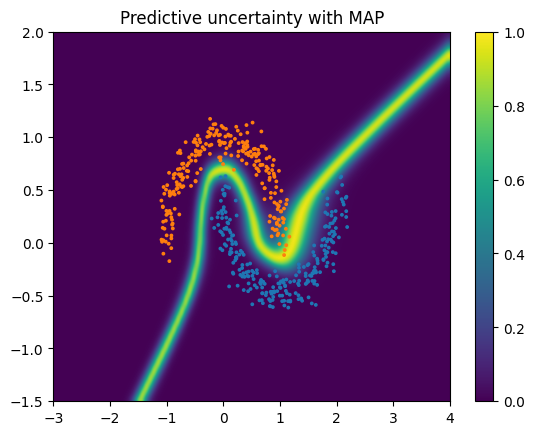

In [6]:
test_modes = compute_test_modes(prob_model, test_data_loader)
grid, grid_inputs_loader = get_grid_inputs_loader(grid_size=100)
grid_entropies = prob_model.predictive.entropy(grid_inputs_loader)
plot_uncertainty_over_grid(
    grid=grid,
    scores=grid_entropies,
    test_modes=test_modes,
    title="Predictive uncertainty with MAP",
)
plt.show()